# L'*Anthologie* comme recueil de *textes* 

Avant toute chose, l'Anthologie est un recueil de textes. Commençons donc par nous intéresser à ceux-ci, et à comprendre comment ils se structurent. 

## Import des librairies nécessaires et chargement des données 

In [1]:
import json
import requests
import csv
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
with open('dump_api.json','r') as f:
    data = json.loads(f.read()) 

Le dump de l'API est désormais contenu dans la variable ```data```. Ses données se structurent comme suit : 

In [3]:
data[1]

{'id': 438,
 'book': {'url': 'https://anthologiagraeca.org/api/books/9/', 'number': 1},
 'fragment': 2,
 'sub_fragment': '',
 'url': 'https://anthologiagraeca.org/api/passages/urn:cts:greekLit:tlg7000.tlg001.ag:1.2/',
 'manuscripts': ['http://digi.ub.uni-heidelberg.de/iiif/2/cpgraec23%3A049.jpg/pct:12.466722876141418,19.26407429979108,58.60226718012693,8.23287268450456/full/0/default.jpg'],
 'texts': [{'url': 'https://anthologiagraeca.org/api/texts/1627/',
   'language': 'grc',
   'text': '\n                      θεῖος Ἰουστῖνος, Σοφίης πόσις, ᾧ πόρε Χριστὸς\n πάντα διορθοῦσθαι, καὶ κλέος ἐν πολέμοις,\nμητρὸς ἀπειρογάμοιο δόμον σκάζοντα νοήσας,\n σαθρὸν ἀποσκεδάσας τεῦξέ μιν ἀσφαλέως.\n'},
  {'url': 'https://anthologiagraeca.org/api/texts/1628/',
   'language': 'eng',
   'text': 'Inscribed on the Apse of Blachernae\n\nThe divine Justin, the husband of Sophia, to whom Christ granted the gift of restoring everything, and glory in war, finding that the temple of the Virgin Mother was tott

Nous pouvons facilement vérifier cela en vérifiant la longueur de la liste : nous devrions obtenir 4134 résultats : le nombre d'épigrammes sur la plateforme. 

In [4]:
print("La liste data contient",len(data), "entrées.")

La liste data contient 4134 entrées.


## Dataframisation des données

Commençons par nous créer un dataframe ```Pandas``` contenant les valeurs suivantes : 

- id de l'épigramme 
- url de l'épigramme 
- url du texte 
- langue du texte 
- texte 

In [5]:
df = pd.DataFrame(columns=['epi_id', 'epi_url', 'text_url', 'text_lang', 'text'])

In [6]:
for item in data:
    texts = item['texts']
    for text in texts:
        df = pd.concat([df, pd.DataFrame({
            'epi_id': [item['id']],
            'epi_url': [item['url']],
            'text_url': [text['url']],
            'text_lang': [text['language']],
            'text': [text['text']]
        })], ignore_index=True)

pd.set_option('display.max_colwidth', None)

In [7]:
df.head()

,epi_id,epi_url,text_url,text_lang,text
0,424,https://anthologiagraeca.org/api/passages/urn:cts:greekLit:tlg7000.tlg001.ag:1.1/,https://anthologiagraeca.org/api/texts/1581/,grc,\n ἃς οἱ πλάνοι καθεῖλον ἐνθάδ᾽ εἰκόνας\n ἄνακτες ἐστήλωσαν εὐσεβεῖς πάλιν.\n
1,424,https://anthologiagraeca.org/api/passages/urn:cts:greekLit:tlg7000.tlg001.ag:1.1/,https://anthologiagraeca.org/api/texts/1582/,eng,Inscribed on the Tabernacle of Saint Sophia\n\nThe images that the hereties took down here our pious sovereigns replaced.
2,424,https://anthologiagraeca.org/api/passages/urn:cts:greekLit:tlg7000.tlg001.ag:1.1/,https://anthologiagraeca.org/api/texts/1583/,fra,"Sur le dais de l'autel de Sainte-Sophie \n\nLes images que des égarés avaient renversées ici, de pieux souverains les ont relevées."
3,424,https://anthologiagraeca.org/api/passages/urn:cts:greekLit:tlg7000.tlg001.ag:1.1/,https://anthologiagraeca.org/api/texts/1584/,por,"Inscrito no altar de Santa Sofia\n \nDaqui os andarilhos derrubaram as imagens,\nEntão os pios senhores as ergueram novamente."
4,438,https://anthologiagraeca.org/api/passages/urn:cts:greekLit:tlg7000.tlg001.ag:1.2/,https://anthologiagraeca.org/api/texts/1627/,grc,"\n θεῖος Ἰουστῖνος, Σοφίης πόσις, ᾧ πόρε Χριστὸς\n πάντα διορθοῦσθαι, καὶ κλέος ἐν πολέμοις,\nμητρὸς ἀπειρογάμοιο δόμον σκάζοντα νοήσας,\n σαθρὸν ἀποσκεδάσας τεῦξέ μιν ἀσφαλέως.\n"


## Normalisation des textes

Nous pouvons normaliser quelque peu les textes avant de nous plonger dans une analyse de ceux-ci. Commençons par enlever les sauts de ligne et la ponctuation. La ponctuation pourrait être intéressante pour certaines analyses mais je ne m'y attarderai pas ici. 

In [8]:
liste_ponctuation = [',', ';', ':', '.', '·', '!','?', '(', ')', '[', ']', '–', '«', '»']
liste_sauts = ['\n', '\r', '-', '\’', '\'']

def normalized(texte): 
    for caractere in liste_ponctuation:
        texte = texte.replace(caractere, '')
    for saut in liste_sauts:
        texte = texte.replace(saut, ' ')
    return texte

In [9]:
df['text'] = df['text'].apply(normalized).str.lower()
df.sample(5)

,epi_id,epi_url,text_url,text_lang,text
2624,1576,https://anthologiagraeca.org/api/passages/urn:cts:greekLit:tlg7000.tlg001.ag:6.317/,https://anthologiagraeca.org/api/texts/9455/,eng,praxiteles carved of parian marble danae and the draped nymphs but me pan he carved of pentelic marble
9990,410,https://anthologiagraeca.org/api/passages/urn:cts:greekLit:tlg7000.tlg001.ag:12.11/,https://anthologiagraeca.org/api/texts/1532/,eng,yesterday i had philostratus for the night but was incapable though he how shall i say it was quite complaisant no longer my friends count me your friend but throw me off a tower as i have become too much of an astyanax
1840,1732,https://anthologiagraeca.org/api/passages/urn:cts:greekLit:tlg7000.tlg001.ag:6.58/,https://anthologiagraeca.org/api/texts/4861/,grc,λέκτρα μάτην μίμνοντα καὶ ἄπρηκτον σκέπας εὐνῆς ἄνθετο σοί μήνη σὸς φίλος ἐνδυμίων αἰδόμενος πολιὴ γὰρ ὅλου κρατέουσα καρήνου οὐ σῴζει προτέρης ἴχνιον ἀγλαΐης
11136,3889,https://anthologiagraeca.org/api/passages/urn:cts:greekLit:tlg7000.tlg001.ag:15.49/,https://anthologiagraeca.org/api/texts/7019/,grc,σοὶ καὶ ἀεθλεύοντι μόνῳ λήξαντὶ τ᾽ ἀέθλων τοῦτο γέρας νίκη δὶς πόρεν οὐράνιε δήμου ἀπ᾽ ἀμφοτέροιο σὺ γὰρ πάρος ἐν βενέτοις μὲν εἴκοσι κυδίστων στέμμα φέρεις ἐτέων παύσαο δ᾽ ἱπποσύνης πρασίνων δέ σε δίζετο δῆμος 5 τοῖσδε σὺ μὲν νίκην οἳ δ᾽ ἄρα σοὶ τὸ γέρας
8387,2393,https://anthologiagraeca.org/api/passages/urn:cts:greekLit:tlg7000.tlg001.ag:9.810/,https://anthologiagraeca.org/api/texts/7389/,eng,this is justin next sophia both made the golden work after their assyrian triumph


## Nombre de textes selon les langues

De là, nous pouvons facilement compter le nombre de textes en grec, en anglais, italien, etc. 

In [10]:
df['text_lang'].value_counts()

grc    4224
eng    3166
fra    2886
ita     944
por     187
cmn     110
lat      39
deu       2
spa       1
Name: text_lang, dtype: int64

Ces données nous permettent de faire notre première visualisation ! Voyons, sous forme de tarte, la répartition des différentes langues au sein des textes de l'AG : 

Text(0.5, 1.0, "Distribution des langues des textes de l'AGr")

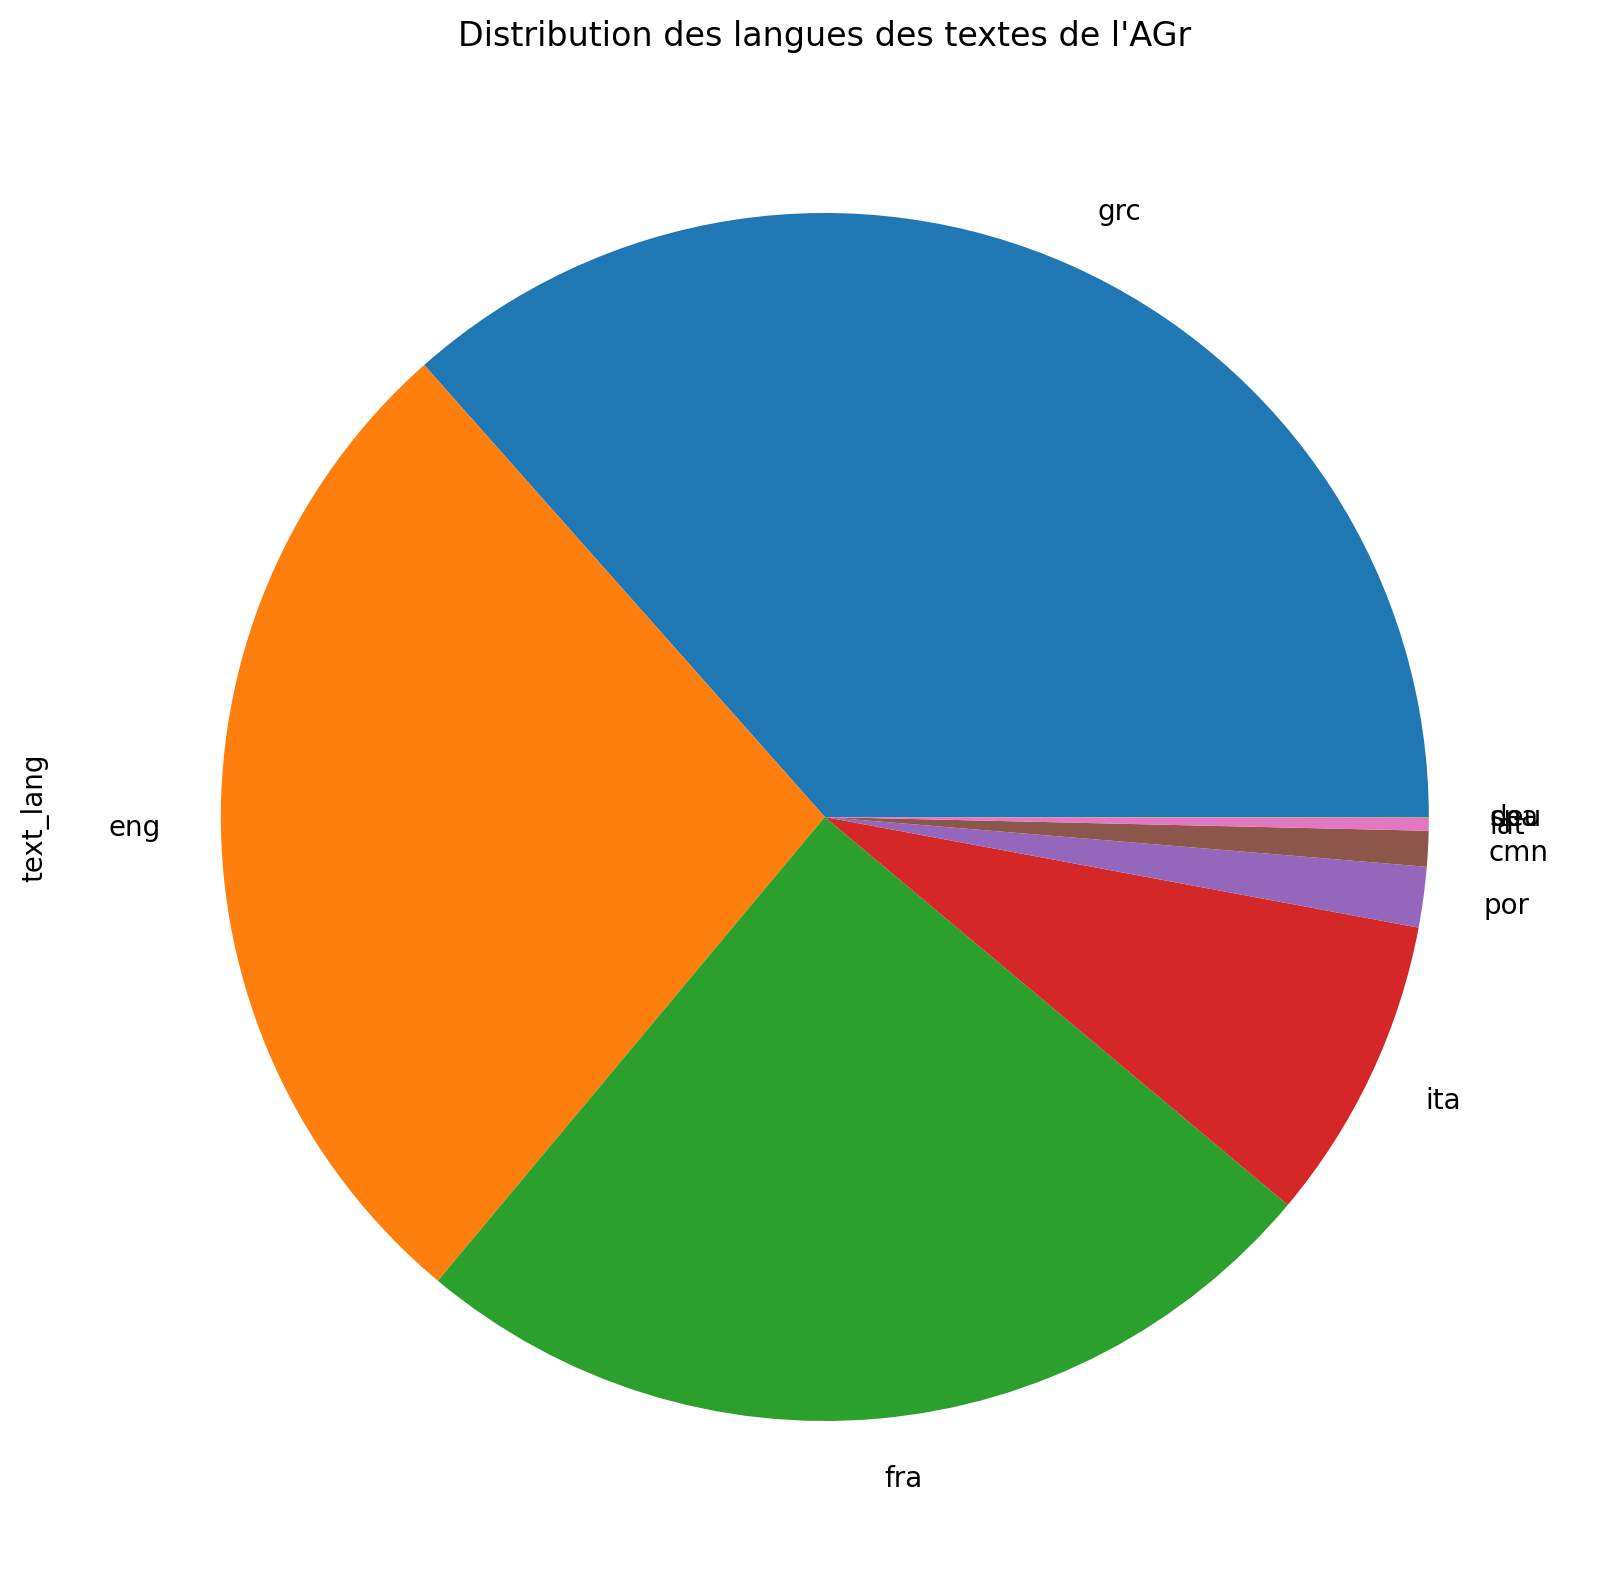

In [11]:
ax = df['text_lang'].value_counts().plot(kind='pie')
fig = plt.gcf()  # Obtient l'objet de la figure courante
fig.set_size_inches(10,10)
fig.set_dpi(200) 
ax.set_title("Distribution des langues des textes de l'AGr")

## Nombre de caractères et de mots par texte 

In [12]:
df['len'] = df['text'].str.len()
df['words'] = df['text'].str.split().str.len()

In [13]:
df[['epi_id', 'epi_url', 'text_url', 'text_lang', 'text', 'len', 'words']]

,epi_id,epi_url,text_url,text_lang,text,len,words
0,424,https://anthologiagraeca.org/api/passages/urn:cts:greekLit:tlg7000.tlg001.ag:1.1/,https://anthologiagraeca.org/api/texts/1581/,grc,ἃς οἱ πλάνοι καθεῖλον ἐνθάδ᾽ εἰκόνας ἄνακτες ἐστήλωσαν εὐσεβεῖς πάλιν,94,10
1,424,https://anthologiagraeca.org/api/passages/urn:cts:greekLit:tlg7000.tlg001.ag:1.1/,https://anthologiagraeca.org/api/texts/1582/,eng,inscribed on the tabernacle of saint sophia the images that the hereties took down here our pious sovereigns replaced,119,19
2,424,https://anthologiagraeca.org/api/passages/urn:cts:greekLit:tlg7000.tlg001.ag:1.1/,https://anthologiagraeca.org/api/texts/1583/,fra,sur le dais de l autel de sainte sophie les images que des égarés avaient renversées ici de pieux souverains les ont relevées,128,23
3,424,https://anthologiagraeca.org/api/passages/urn:cts:greekLit:tlg7000.tlg001.ag:1.1/,https://anthologiagraeca.org/api/texts/1584/,por,inscrito no altar de santa sofia daqui os andarilhos derrubaram as imagens então os pios senhores as ergueram novamente,121,19
4,438,https://anthologiagraeca.org/api/passages/urn:cts:greekLit:tlg7000.tlg001.ag:1.2/,https://anthologiagraeca.org/api/texts/1627/,grc,θεῖος ἰουστῖνος σοφίης πόσις ᾧ πόρε χριστὸς πάντα διορθοῦσθαι καὶ κλέος ἐν πολέμοις μητρὸς ἀπειρογάμοιο δόμον σκάζοντα νοήσας σαθρὸν ἀποσκεδάσας τεῦξέ μιν ἀσφαλέως,189,23
...,...,...,...,...,...,...,...
11554,4125,https://anthologiagraeca.org/api/passages/urn:cts:greekLit:tlg7000.tlg001.ag:16.386/,https://anthologiagraeca.org/api/texts/14199/,ita,l artista a morti da gran tempo vita dà giuliano tira e molla le sue redini sul carro rosso con vigore come un dì si leva col suo carro nell immagine la mano è là che attende il cenno pista via,198,41
11555,3523,https://anthologiagraeca.org/api/passages/urn:cts:greekLit:tlg7000.tlg001.ag:16.387/,https://anthologiagraeca.org/api/texts/6652/,grc,ἰουλιανὸς οὗτος ἅρμα ῥουσίου ἔχων ἐνίκα τοὺς ἐναντίους δρόμῳ ἀλλ᾽ εἰ γραφεὺς παρεῖχε καὶ πνοῆς χάριν ἕτοιμός ἐστι καὶ πάλιν διφρηλάτης καὶ πρόσθεν ἐλθεῖν καὶ λαβεῖν καὶ τὸ στέφος,200,29
11556,3523,https://anthologiagraeca.org/api/passages/urn:cts:greekLit:tlg7000.tlg001.ag:16.387/,https://anthologiagraeca.org/api/texts/14200/,ita,giuliano è questo per i rossi vincere poté i rivali tutti nell ippodromo e se il pittore gl infondeva l alito sarebbe pronto nuovamente a correre a dominare la corona a cingere,180,32
11557,3946,https://anthologiagraeca.org/api/passages/urn:cts:greekLit:tlg7000.tlg001.ag:16.388/,https://anthologiagraeca.org/api/texts/7076/,grc,στέφος πλέκων ποθ᾽ εὗρον ἐν τοῖς ῥόδοις ἔρωτα καὶ τῶν πτερῶν κατασχὼν ἐβάπτις1᾽ εἰς τὸν οἶνον λαβὼν δ᾽ ἔπιον αὐτόν καὶ νῦν ἔσω μελῶν μου πτεροῖσι γαργαλίζει,179,27


Voyons le nombre total de caractère pour chacune des langues : 

In [14]:
sum_len = df.groupby('text_lang')['len'].sum()
sum_words = df.groupby('text_lang')['words'].sum()

In [15]:
print(sum_len)
print(sum_words)

text_lang
cmn      9252
deu       400
eng    810834
fra    828307
grc    989693
ita    254731
lat      8337
por     50421
spa       202
Name: len, dtype: int64
text_lang
cmn       162
deu        65
eng    155135
fra    157244
grc    139731
ita     44519
lat      1287
por      9102
spa        37
Name: words, dtype: int64


Text(0.5, 1.0, "Nombre de caractère par langues au sein des textes de l'AGr")

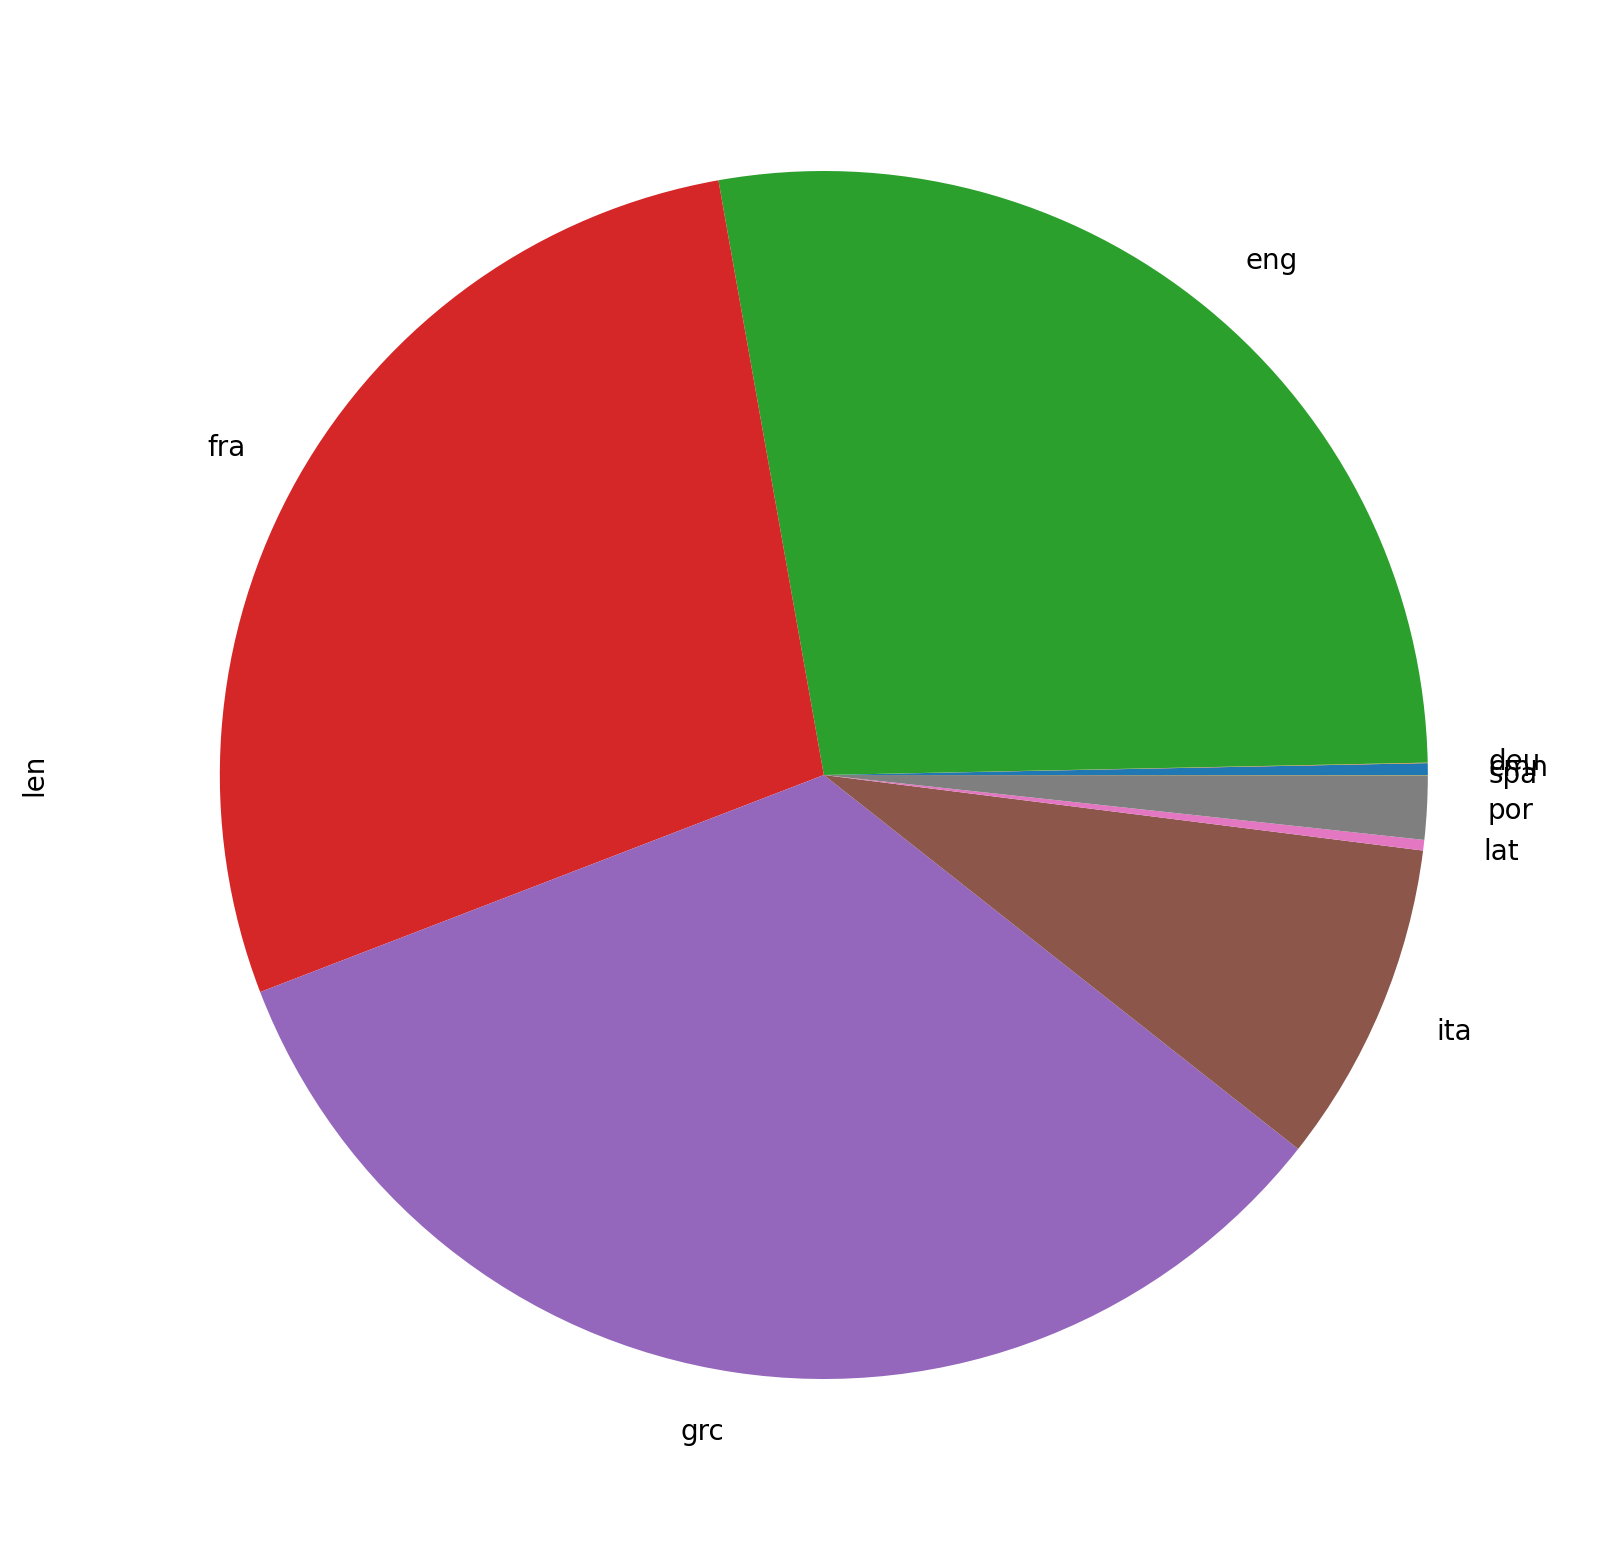

In [16]:
ax1 = sum_len.plot(kind='pie')
fig = plt.gcf()  # Obtient l'objet de la figure courante
fig.set_size_inches(10,10)
fig.set_dpi(200) 
ax.set_title("Nombre de caractère par langues au sein des textes de l'AGr")

Text(0.5, 1.0, "Nombre de mots par langues au sein des textes de l'AGr")

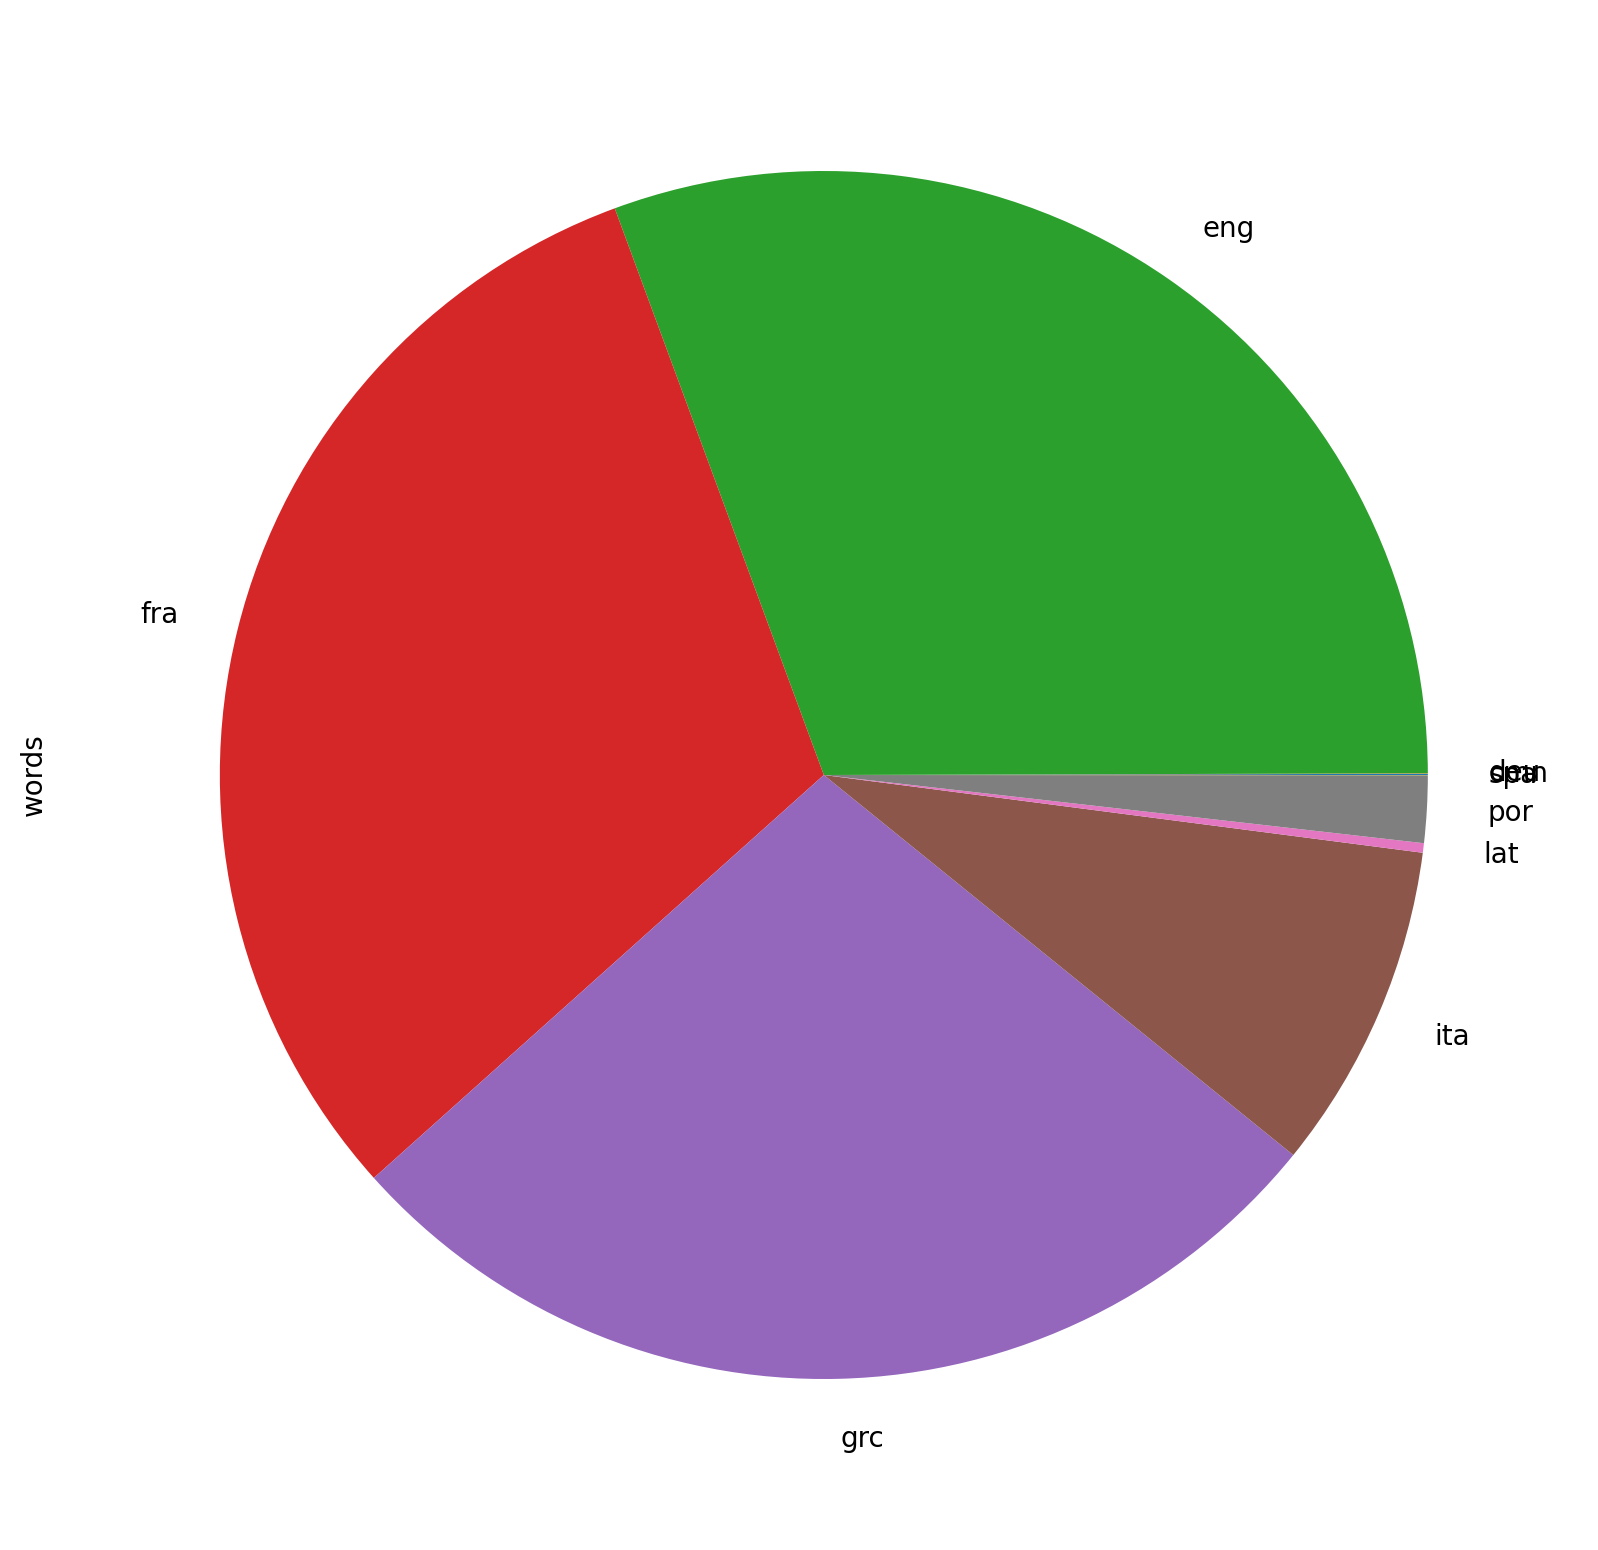

In [17]:
ax1 = sum_words.plot(kind='pie')
fig = plt.gcf()  # Obtient l'objet de la figure courante
fig.set_size_inches(10,10)
fig.set_dpi(200) 
ax.set_title("Nombre de mots par langues au sein des textes de l'AGr")

On pourrait également calculer le nombre moyen de caractères et de mots par épigramme en fonction des langues : 

In [18]:
mean_len = df.groupby('text_lang')['len'].mean()
print(mean_len)

mean_word = df.groupby('text_lang')['words'].mean()
print(mean_word)

text_lang
cmn     84.109091
deu    200.000000
eng    256.106759
fra    287.008663
grc    234.302320
ita    269.842161
lat    213.769231
por    269.631016
spa    202.000000
Name: len, dtype: float64
text_lang
cmn     1.472727
deu    32.500000
eng    49.000316
fra    54.485100
grc    33.080256
ita    47.159958
lat    33.000000
por    48.673797
spa    37.000000
Name: words, dtype: float64


Text(0.5, 1.0, "Nombre moye de caractère par épigramme au sein de l'AGr selon les langues")

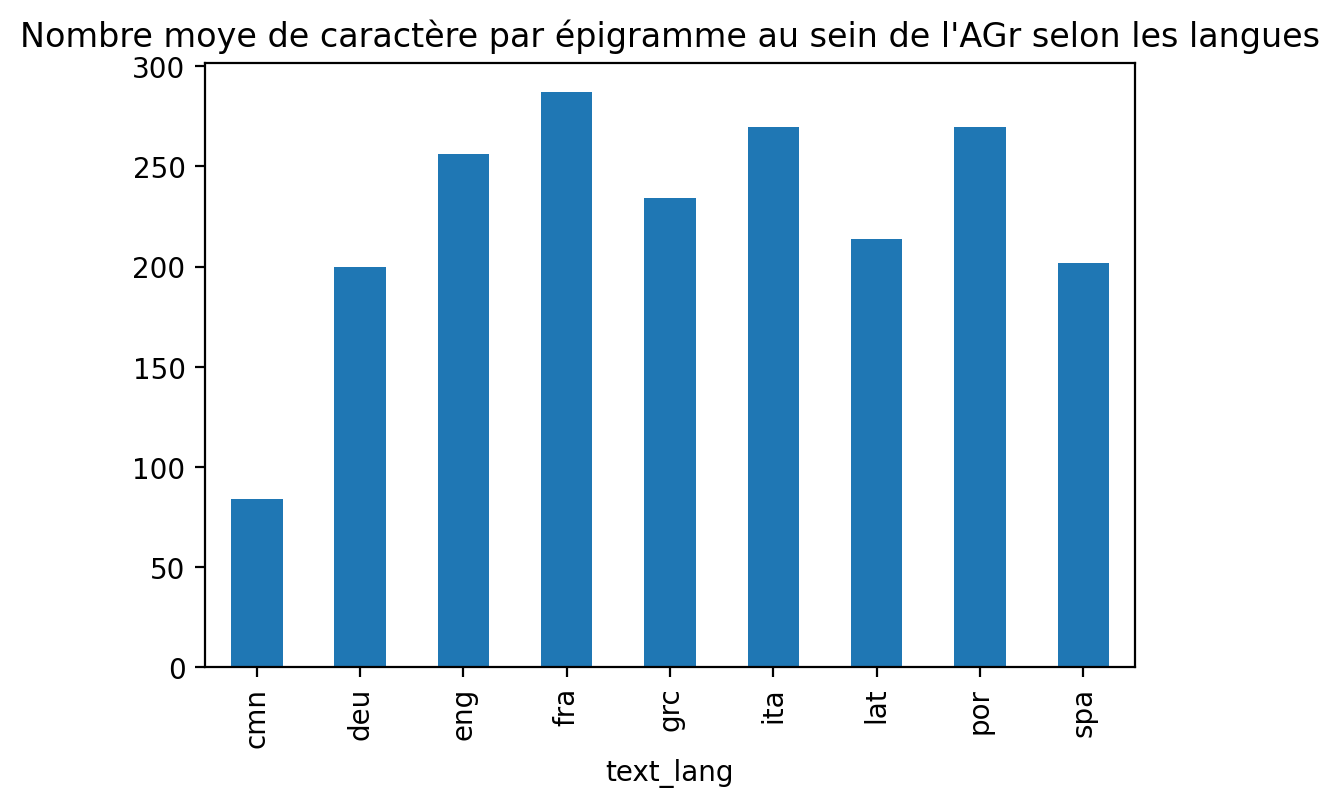

In [19]:
ax = mean_len.plot(kind='bar')
fig = plt.gcf()  # Obtient l'objet de la figure courante
fig.set_dpi(200) 
ax.set_title("Nombre moye de caractère par épigramme au sein de l'AGr selon les langues")

Text(0.5, 1.0, "Nombre moyen de mots par épigramme au sein de l'AGr selon les langues")

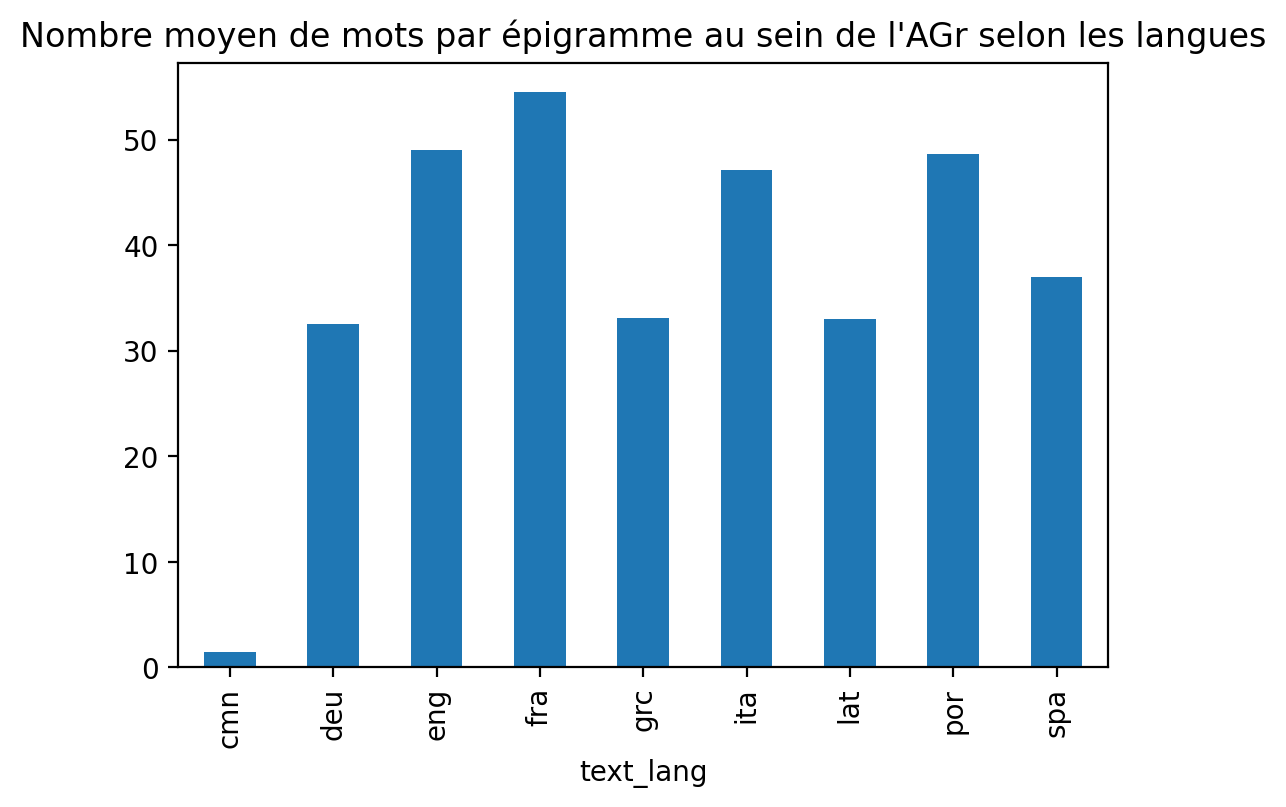

In [20]:
ax = mean_word.plot(kind='bar')
fig = plt.gcf()  # Obtient l'objet de la figure courante
fig.set_dpi(200) 
ax.set_title("Nombre moyen de mots par épigramme au sein de l'AGr selon les langues")